In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from datetime import datetime

In [113]:
# Define file path for training data
train_file = "../Data/Train/trains1990s.csv"

# Load Training Data
train_df = pd.read_csv(train_file, parse_dates=['observation_date'])
train_df = train_df.rename(columns={'fred_PCEPI': 'PCE'})
train_df.set_index('observation_date', inplace=True)

# Fit the scaler on the training data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['PCE']])

# Convert the scaled data to 1D arrays
train_series = train_scaled.flatten()

# Create Sequences from the Data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i : i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

# Set the sequence length
sequence_length = 12

# Split Data into Training and Validation Sets (80/20 split)
split_index = int(len(train_series) * 0.8)
# For training, use data up to the split_index
train_data = train_series[:split_index]

# For validation, include overlap for sequences 
val_data = train_series[split_index - sequence_length:]
X_train, y_train = create_sequences(train_series, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/ipykernel_8065/2270751058.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df = pd.read_csv(train_file, parse_dates=['observation_date'])


In [114]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        # Define computation device (GPU if available, otherwise CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Define a fully connected layer for the final output
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialise hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate through the LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Take the output from the last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)

In [115]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []
val_losses = []

In [116]:
from EarlyStopping import EarlyStopping
early_stopping = EarlyStopping(tol=1e-3, patientce=15)


In [117]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Evaluate on validation set
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")
    
    # Check early stopping
    if early_stopping(model, epoch_val_loss):
        early_stop_epoch = epoch + 1  # record the epoch where training stopped
        print(f"Early stopping triggered at epoch {early_stop_epoch}")
        break

# Restore best model weights after early stopping
early_stopping.restoreBestWeights(model)


Epoch 1/50 - Train Loss: 0.2508 - Val Loss: 0.4738
Epoch 2/50 - Train Loss: 0.0838 - Val Loss: 0.1113
Epoch 3/50 - Train Loss: 0.0464 - Val Loss: 0.0209
Epoch 4/50 - Train Loss: 0.0704 - Val Loss: 0.0526
Epoch 5/50 - Train Loss: 0.0416 - Val Loss: 0.0333
Epoch 6/50 - Train Loss: 0.0308 - Val Loss: 0.0104
Epoch 7/50 - Train Loss: 0.0252 - Val Loss: 0.0053
Epoch 8/50 - Train Loss: 0.0125 - Val Loss: 0.0002
Epoch 9/50 - Train Loss: 0.0049 - Val Loss: 0.0002
Epoch 10/50 - Train Loss: 0.0040 - Val Loss: 0.0020
Epoch 11/50 - Train Loss: 0.0026 - Val Loss: 0.0013
Epoch 12/50 - Train Loss: 0.0019 - Val Loss: 0.0003
Epoch 13/50 - Train Loss: 0.0021 - Val Loss: 0.0009
Epoch 14/50 - Train Loss: 0.0016 - Val Loss: 0.0003
Epoch 15/50 - Train Loss: 0.0018 - Val Loss: 0.0009
Epoch 16/50 - Train Loss: 0.0013 - Val Loss: 0.0003
Epoch 17/50 - Train Loss: 0.0013 - Val Loss: 0.0005
Epoch 18/50 - Train Loss: 0.0010 - Val Loss: 0.0003
Epoch 19/50 - Train Loss: 0.0009 - Val Loss: 0.0003
Epoch 20/50 - Train L

In [118]:
X_all, _ = create_sequences(train_series, sequence_length)
X_all_tensor = torch.tensor(X_all, dtype=torch.float32).unsqueeze(-1)

model.eval()
with torch.no_grad():
    all_predictions = model(X_all_tensor.to(device)).cpu().numpy()

# Inverse transform predictions and actual values
all_predictions_inv = scaler.inverse_transform(all_predictions)
# Actual values starting from index `sequence_length`
actual_all = train_df['PCE'].values[sequence_length:]
all_dates = train_df.index[sequence_length:]


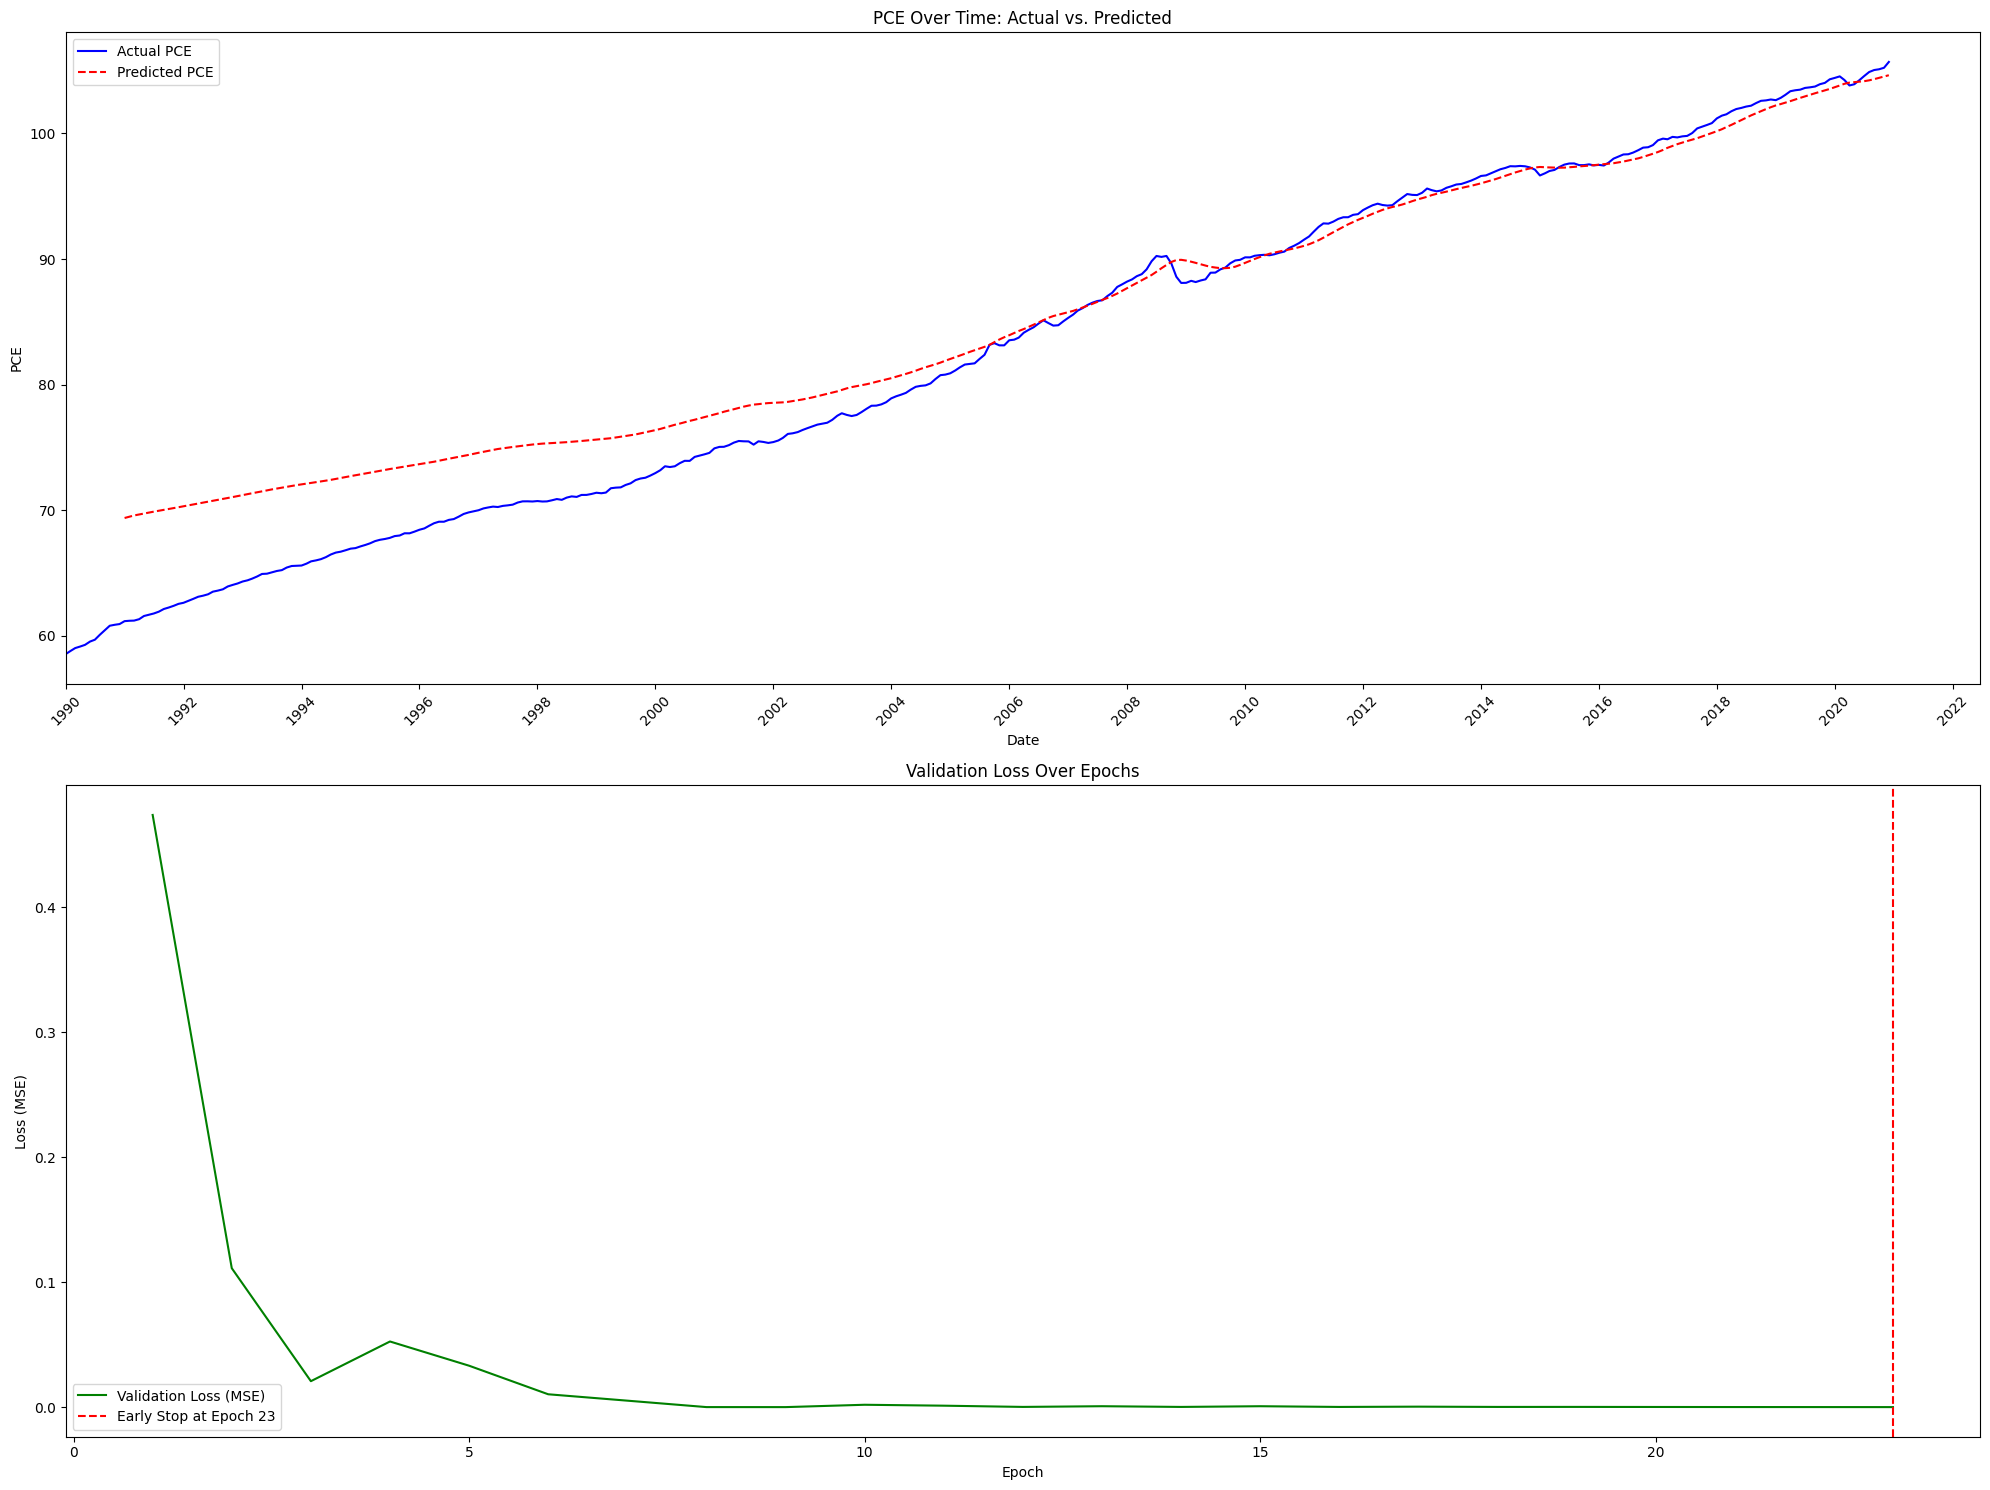

In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

# Plot the entire actual PCE and predicted PCE line
ax1.plot(train_df.index, train_df['PCE'], label='Actual PCE', color='blue')
ax1.plot(all_dates, all_predictions_inv, label='Predicted PCE', linestyle='--', color='red')
ax1.set_title("PCE Over Time: Actual vs. Predicted")
ax1.set_xlabel("Date")
ax1.set_ylabel("PCE")
ax1.legend()
ax1.set_xlim([datetime(1990, 1, 1), None])
ax1.xaxis.set_major_locator(mdates.YearLocator(2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', rotation=45)

# Plot Validation Loss over Epochs with a vertical line for early stopping
ax2.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss (MSE)', color='green')
ax2.axvline(x=early_stop_epoch, color='red', linestyle='--', label=f"Early Stop at Epoch {early_stop_epoch}")
ax2.set_title("Validation Loss Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss (MSE)")
ax2.legend()

plt.tight_layout()
plt.show()